# Hyperparameter Optimization with aqua-blue

Prediction accuracy is highly correlated to the hyperparameters of a reservoir computer. The `hyper` module provides functionality to optimize hyperparameters through random search algorithms. In this example, we demonstrate hyperparameter optimization using aqua-blue's `hyper` module. **Note that this is an experimental feature and is subject to change. Any feedback is appreciated.**

## Aqua-blue Hyperparameters
Aqua-blue models have 4 hyperparameters with significant effect on prediction accuracy. 

### Spectral Radius ($r_s$)
The spectral radius is the largest absolute eigenvalue of the reservoir weight matrix, $W_{res}$. It controls the echo state property of the system, ensuring that memory of past states gradually fades over time. The approximate ranges which define behavior for general use cases are given below, however the best way to determine the optimal $s_r$ for a task is using an optimization algorithm.
$$r_s < 1 \to \text{ stable dynamics, past states fade quickly}$$
$$r_s \approx 1 \to \text{ balance between past states and current input}$$ 
$$r_s > 1 \to \text{ chaotic dynamics, could lead to numerical instability }$$

### Sparsity
The sparsity is the proportion of zero entries in the reservoir weight matrix $W_{res}$. It determines the extent of connection between neurons. Higher sparsity values lead to reduced computation at the cost of higher overfitting risk. Lower sparsity values increase neuron connection density, which leads to more complex dynamics at the price of higher computational cost.

### Leaking Rate ($\alpha$) 
The leaking rate controls the priority of past states versus current states. At each timestep, 
    $$y_t = (1 - \alpha) y_{t-1} + \alpha f(W_\text{in} x_t + W_\text{res} y_{t-1})$$
where $y_t$ and $y_{t-1}$ are reservoir states and $x_t$ is an input state. Therefore, the leaking rate is directly proportional to how fast the model updates.

### rcond 
The output later is trained using ridge regression, which involves computing the Moore-Penrose pseudo-inverse. `rcond` is a cutoff for small singular values, which is used to improve numerical stability.

## Basic Hyperparameter Optimization

The `hyper` module implements certain classes to simplify usage of the `hyperopt` package. We will demonstrate its usage with an example.

Let's define a time series that we want to predict the future of.

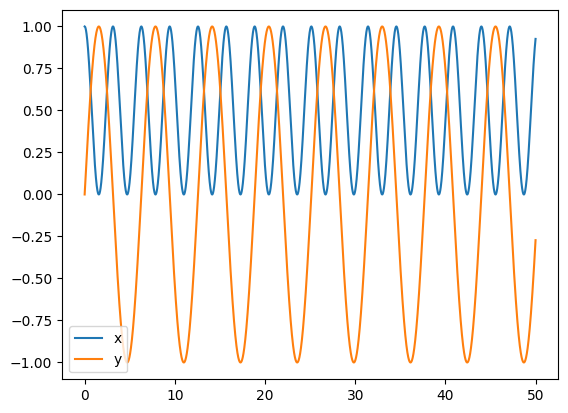

In [4]:
import numpy as np 
import aqua_blue 
import aqua_blue_hyperopt
import matplotlib.pyplot as plt 

t = np.arange(5_000) / 100
y = np.vstack((np.cos(t) ** 2, np.sin(t))).T

time_series = aqua_blue.time_series.TimeSeries(dependent_variable=y, times=t)

plt.plot(time_series.times, time_series.dependent_variable, label=['x', 'y'])
plt.legend()
plt.show()

We want to predict `1000` timesteps into the future. Since this is a simple function, we can compute the actual future easily.

In [5]:
horizon = 1000
p_times = np.linspace(t[-1], t[-1] + horizon*np.diff(t)[0], horizon)
actual_future =  np.vstack((np.cos(p_times) ** 2, np.sin(p_times))).T

We will also use a NumPy PRNG to generate our weight matrices.

In [6]:
generator = np.random.default_rng(seed=0)
w_res = generator.uniform(
    low=-0.5,
    high=0.5,
    size=(100, 100)
)
w_in = generator.uniform(
    low=-0.5,
    high=0.5,
    size=(100, 2)
)

First, we will predict with the default hyperparameters.

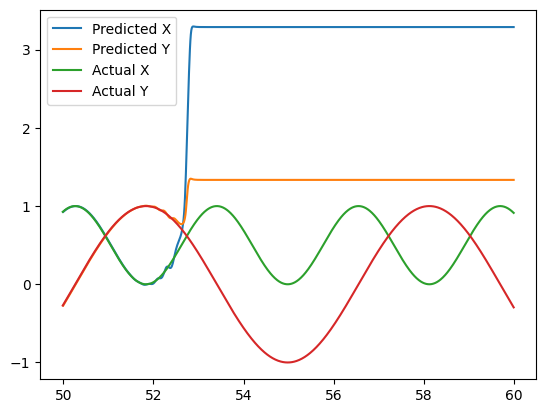

In [7]:
normalizer = aqua_blue.utilities.Normalizer()

n_ts = normalizer.normalize(time_series)

model = aqua_blue.models.Model(
    aqua_blue.reservoirs.DynamicalReservoir(
        input_dimensionality=2,
        reservoir_dimensionality=100, 
        w_in=w_in, 
        w_res=w_res, 
    ),
    readout=aqua_blue.readouts.LinearReadout()
)
model.train(n_ts) 

prediction = normalizer.denormalize(model.predict(horizon))

plt.plot(prediction.times, prediction.dependent_variable, label=['Predicted X', 'Predicted Y'])
plt.plot(p_times, actual_future, label=["Actual X", "Actual Y"])
plt.legend()
plt.show()

As expected, the prediction is pretty poor because the hyperparameters aren't tuned for this specific problem. To do so, we start by defining a `ModelParams` object, which provides information about the model to the optimizer.

In [10]:
mp = aqua_blue_hyperopt.hyper.ModelParams(
    time_series=time_series,
    input_dimensionality=2, 
    reservoir_dimensionality=100,
    w_in=w_in,
    w_res=w_res, 
    horizon=horizon,
    actual_future=actual_future
)

Now, we need a way of computing how good our prediction is. We will use the RMSE (Root Mean Squared Error) as a metric for this example, which is the metric that `hyper` defaults to. We will run our optimizer for 1000 iterations.

In [11]:
fmin = aqua_blue_hyperopt.hyper.default_loss(mp)
evals = 1000

Let's create an `Optimizer` and pass the objective function and number of iterations. Then, we call the `.optimize()` method to get the optimal hyperparameters. Note that this will take time, depending on your system requirements. 

In [21]:
optimizer = aqua_blue_hyperopt.hyper.Optimizer(fn=fmin, max_evals=evals)
best_params = optimizer.optimize()

100%|██████████| 1000/1000 [02:49<00:00,  5.91trial/s, best loss: 0.027156923808887522]


We have our optimal hyperparameters!

In [22]:
print(best_params)

{'leaking_rate': np.float64(0.015987210943515184), 'rcond': np.float64(0.003298524977828134), 'sparsity': np.float64(0.9206275556057627), 'spectral_radius': np.float64(0.8548149183873395)}


To verify that the optimizer has done its job, let's create a model with these parameters and make a prediction.

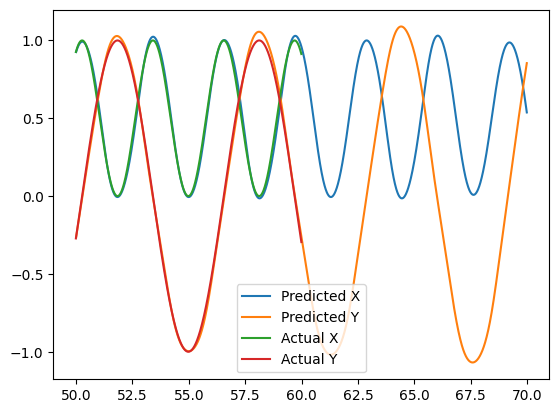

In [26]:
normalizer = aqua_blue.utilities.Normalizer()

n_ts = normalizer.normalize(time_series)

model = aqua_blue.models.Model(
    aqua_blue.reservoirs.DynamicalReservoir(
        input_dimensionality=2,
        reservoir_dimensionality=100, 
        w_in=w_in, 
        w_res=w_res, 
        spectral_radius=best_params['spectral_radius'], 
        sparsity=best_params['sparsity'],
        leaking_rate=best_params['leaking_rate'], 
    ),
    readout=aqua_blue.readouts.LinearReadout(rcond=best_params['rcond'])
)
model.train(n_ts) 

prediction = normalizer.denormalize(model.predict(2*horizon))

plt.plot(prediction.times, prediction.dependent_variable, label=['Predicted X', 'Predicted Y'])
plt.plot(p_times, actual_future, label=["Actual X", "Actual Y"])
plt.legend()
plt.show()

Now, our prediction is looking a lot nicer! Note that the horizon in this cell is twice what was used for hyperparameter optimization, which means that once the optimal hyperparameters are determined for a specific problem, they can be used for predictions of any length.

## Advanced Hyperparameter Optimization

The example provided above uses the default `Optimizer` settings. While this works for a general use case, specific problems might require more customization. `hyper` provides the following advanced functionalities - 
- User-defined hyperparameter search space 
- User-defined objective function 
- Optimization algorithm choices
- User-defined output

### User-defined hyperparameter search space 
`hyper`'s default hyperparameter search space spans the range of theoretically favorable values. 

In [17]:
import hyperopt
from aqua_blue_hyperopt.hyper import HyperParams

default_space: HyperParams = {
    'spectral_radius': hyperopt.hp.uniform('spectral_radius', 0.1, 1.5),
    'leaking_rate': hyperopt.hp.uniform('leaking_rate', 0.0, 1.0),
    'sparsity': hyperopt.hp.uniform('sparsity', 0.0, 1.0),
    'rcond': hyperopt.hp.uniform('rcond', 1e-8, 1e-2)
}

However, `hyperopt` defines several search spaces which might be useful for certain problems. 

In [27]:
custom_space : HyperParams = { 
    'spectral_radius': hyperopt.hp.lognormal('spectral_radius', 0.1, 1.5), 
    'leaking_rate': hyperopt.hp.lognormal('leaking_rate', 0.0, 1.0), 
    'sparsity': hyperopt.hp.lognormal('sparsity', 0.0, 1.0), 
    'rcond': hyperopt.hp.uniform('rcond', 1e-8, 1e-2)
}

Custom search spaces can be used as follows: 

In [ ]:
optimizer = aqua_blue_hyperopt.hyper.Optimizer(
    max_evals=10, 
    fn=fmin, 
    space=custom_space
)

best = optimizer.optimize()

### User-defined objective function
`hyper`'s default objective function is `default_loss`, which is a factory that takes in a `ModelParams` object, and outputs a `Callable`. The `Callable` takes a `HyperParams` dictionary and outputs the RMSE.

In [29]:
from aqua_blue_hyperopt.hyper import ModelParams, Output
from aqua_blue.utilities import Normalizer
from aqua_blue.models import Model
from aqua_blue.reservoirs import DynamicalReservoir
from aqua_blue.readouts import LinearReadout

from typing import Callable
import warnings

def default_loss(mp: ModelParams) -> Callable[[HyperParams], Output]:
    def inner(p : HyperParams) -> Output: 
        spectral_radius, leaking_rate, sparsity, rcond = p['spectral_radius'], p['leaking_rate'], p['sparsity'], p['rcond']
        
        normalizer = Normalizer()
        
        model = Model( 
            reservoir=DynamicalReservoir(
                reservoir_dimensionality = mp.reservoir_dimensionality, 
                input_dimensionality = mp.input_dimensionality,
                w_res = mp.w_res, 
                w_in = mp.w_in,
                spectral_radius = spectral_radius,
                leaking_rate = leaking_rate, 
                sparsity = sparsity
            ),
            readout = LinearReadout(rcond = rcond)
        )

        normalized_time_series = normalizer.normalize(mp.time_series)
        
        try: 
            model.train(normalized_time_series)
        except np.linalg.LinAlgError:
            warnings.warn('SVD Error in Training', RuntimeWarning)
            return { 
                'loss': 1000, 
                'status': hyperopt.STATUS_FAIL
            }
        
        try: 
            prediction = model.predict(horizon = mp.horizon)
        except np.linalg.LinAlgError:
            warnings.warn('SVD Error in Training', RuntimeWarning)
            return { 
                'loss': 1000, 
                'status': hyperopt.STATUS_FAIL
            }
        
        prediction = normalizer.denormalize(prediction)
        
        if prediction.dependent_variable.shape != mp.actual_future.shape:
            raise ValueError('Dimension mismatch between actual future and prediction')
        
        loss = np.sqrt(np.mean((mp.actual_future - prediction.dependent_variable) ** 2))
        
        out : Output = { 
            'loss': loss, 
            'status': hyperopt.STATUS_OK
        }
        
        return out 
    
    return inner

`hyper` provides functionality to define a custom objective function, which is `Callable[[HyperParams], Output]` or a factory that produces such a `Callable`. Let's say we want to calculate the MSE (Mean Squared Error) instead.  

In [30]:
def MSE(mp: ModelParams) -> Callable[[HyperParams], Output]:
    def inner(p : HyperParams) -> Output: 
        spectral_radius, leaking_rate, sparsity, rcond = p['spectral_radius'], p['leaking_rate'], p['sparsity'], p['rcond']
        
        normalizer = Normalizer()
        
        model = Model( 
            reservoir=DynamicalReservoir(
                reservoir_dimensionality = mp.reservoir_dimensionality, 
                input_dimensionality = mp.input_dimensionality,
                w_res = mp.w_res, 
                w_in = mp.w_in,
                spectral_radius = spectral_radius,
                leaking_rate = leaking_rate, 
                sparsity = sparsity
            ),
            readout = LinearReadout(rcond = rcond)
        )

        normalized_time_series = normalizer.normalize(mp.time_series)
        
        try: 
            model.train(normalized_time_series)
        except np.linalg.LinAlgError:
            warnings.warn('SVD Error in Training', RuntimeWarning)
            return { 
                'loss': 1000, 
                'status': hyperopt.STATUS_FAIL
            }
        
        try: 
            prediction = model.predict(horizon = mp.horizon)
        except np.linalg.LinAlgError:
            warnings.warn('SVD Error in Training', RuntimeWarning)
            return { 
                'loss': 1000, 
                'status': hyperopt.STATUS_FAIL
            }
        
        prediction = normalizer.denormalize(prediction)
        
        if prediction.dependent_variable.shape != mp.actual_future.shape:
            raise ValueError('Dimension mismatch between actual future and prediction')
        
        loss = np.mean((mp.actual_future - prediction.dependent_variable) ** 2)
        
        out : Output = { 
            'loss': loss, 
            'status': hyperopt.STATUS_OK
        }
        
        return out 
    
    return inner

Custom objective functions are used as follows:


In [ ]:
custom_fn = MSE(mp)

optimizer = aqua_blue_hyperopt.hyper.Optimizer(
    max_evals=10, 
    fn=custom_fn
)

best = optimizer.optimize()

### Optimization Algorithm Choices

`hyper` provides functionality to choose between these optimization algorithms: 
- Tree-structured Parzen Estimator
- Simulated Annealing 
- Random Search

By default, random search is used. However, the other optimization algorithms can be chosen using the `Algo` Enum class.


In [ ]:
from aqua_blue_hyperopt.hyper import Algo

optimizer = aqua_blue_hyperopt.hyper.Optimizer(fn=fmin, algo=Algo.SIMULATED_ANNEALING, max_evals=10)
best_params = optimizer.optimize()

**Because the hyperparameter space is relatively small, it is our recommendation that `Algo.GRID_SEARCH` be used for most applications.**

### User defined output

Custom metrics can be extracted from the optimization runs by inheriting from `aqua_blue.hyper.Output` and using `hyperopt.Trials`


In [34]:
from aqua_blue_hyperopt.hyper import Output, ModelParams

class CustomOutput(Output):
    accuracy: float # 1 - loss

def loss(mp: ModelParams) -> Callable[[HyperParams], CustomOutput]:
    def inner(p : HyperParams) -> Output: 
        spectral_radius, leaking_rate, sparsity, rcond = p['spectral_radius'], p['leaking_rate'], p['sparsity'], p['rcond']
        
        normalizer = Normalizer()
        
        model = Model( 
            reservoir=DynamicalReservoir(
                reservoir_dimensionality = mp.reservoir_dimensionality, 
                input_dimensionality = mp.input_dimensionality,
                w_res = mp.w_res, 
                w_in = mp.w_in,
                spectral_radius = spectral_radius,
                leaking_rate = leaking_rate, 
                sparsity = sparsity
            ),
            readout = LinearReadout(rcond = rcond)
        )

        normalized_time_series = normalizer.normalize(mp.time_series)
        
        try: 
            model.train(normalized_time_series)
        except np.linalg.LinAlgError:
            warnings.warn('SVD Error in Training', RuntimeWarning)
            return { 
                'loss': 1000, 
                'status': hyperopt.STATUS_FAIL,
                'accuracy': 0
            }
        
        try: 
            prediction = model.predict(horizon = mp.horizon)
        except np.linalg.LinAlgError:
            warnings.warn('SVD Error in Training', RuntimeWarning)
            return { 
                'loss': 1000, 
                'status': hyperopt.STATUS_FAIL,
                'accuracy': 0
            }
        
        prediction = normalizer.denormalize(prediction)
        
        if prediction.dependent_variable.shape != mp.actual_future.shape:
            raise ValueError('Dimension mismatch between actual future and prediction')
        
        loss = np.sqrt(np.mean((mp.actual_future - prediction.dependent_variable) ** 2))
        
        out : Output = { 
            'loss': loss, 
            'status': hyperopt.STATUS_OK, 
            'accuracy': 1-loss
        }
        
        return out 
    
    return inner

In [ ]:
custom_fn = loss(mp)
trials = hyperopt.Trials()

optimizer = aqua_blue_hyperopt.hyper.Optimizer(
    max_evals=10, 
    fn=custom_fn,
    trials=trials
)

best = optimizer.optimize()

In [37]:
for i in trials.trials:
    print(i['result'])

{'loss': 0.8811130565427164, 'status': 'ok', 'accuracy': np.float64(0.11888694345728357)}
{'loss': 0.9860692960727964, 'status': 'ok', 'accuracy': np.float64(0.013930703927203636)}
{'loss': 0.9894853895913511, 'status': 'ok', 'accuracy': np.float64(0.010514610408648872)}
{'loss': 0.9223981214679865, 'status': 'ok', 'accuracy': np.float64(0.0776018785320135)}
{'loss': 0.9877413536886591, 'status': 'ok', 'accuracy': np.float64(0.012258646311340882)}
{'loss': 1.0510615266394865, 'status': 'ok', 'accuracy': np.float64(-0.05106152663948649)}
{'loss': 0.6050589885219521, 'status': 'ok', 'accuracy': np.float64(0.39494101147804794)}
{'loss': 0.6347520431305029, 'status': 'ok', 'accuracy': np.float64(0.36524795686949707)}
{'loss': 0.6596451074797887, 'status': 'ok', 'accuracy': np.float64(0.34035489252021134)}
{'loss': 0.628221573447381, 'status': 'ok', 'accuracy': np.float64(0.37177842655261895)}


This makes it easy to save trials to disk using `pickle` or other packages.